In [61]:
import sys
import torch
import warnings
import numpy as np
import torch.nn as nn
import torch.optim as optim

from matplotlib import pyplot as plt
from torch.utils.data import TensorDataset, DataLoader 

warnings.filterwarnings('ignore')
np.set_printoptions(threshold=sys.maxsize)

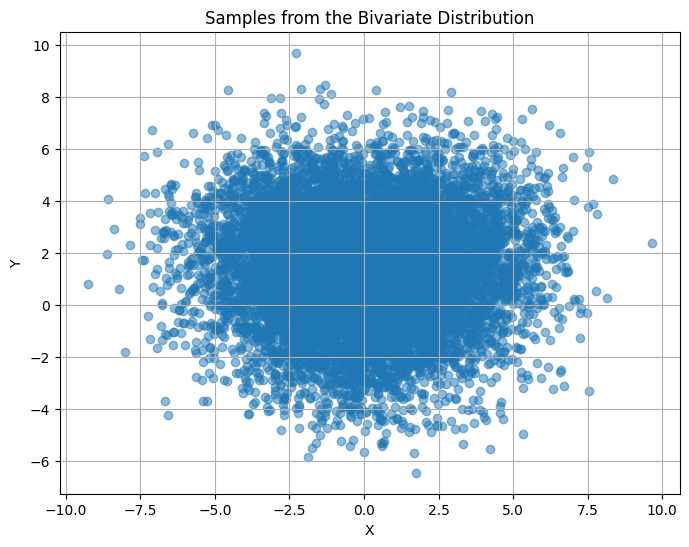

In [62]:
sigma = 2
num = 10000
covariance = sigma**2 * np.eye(2)
mu_list = [np.array([0, 0]), np.array([2, 2]), np.array([-2, 2])]

data = []
for _ in range(num):
    idx = np.random.choice(len(mu_list))
    mu = mu_list[idx]
    sample = np.random.multivariate_normal(mu, covariance)
    data.append(sample)

data = np.array(data)
plt.figure(figsize=(8, 6))
plt.scatter(data[:, 0], data[:, 1], alpha=0.5)
plt.title('Samples from the Bivariate Distribution')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.show()

In [63]:
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )

    def forward(self, x):
        return self.fc(x)
    
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.fc(x)

In [64]:
n_epochs = 100
batch_size = 64
learn_rate = 0.0002

latent_dim = 2
data_dim = 2

# create dataset and prepare the models
dataset = TensorDataset(torch.tensor(data, dtype=torch.float32))
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

generator = Generator(latent_dim, data_dim)
discriminator = Discriminator(data_dim)

loss_func = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=learn_rate)
optimizer_D = optim.Adam(discriminator.parameters(), lr=learn_rate)

# train the model and record the losses
losses_G, losses_D = [], []
for _ in range(n_epochs):
    loss_G, loss_D = 0, 0
    for data in dataloader:
        # Train discriminator
        discriminator.zero_grad()
        real_data = data[0]
        b_size = real_data.size(0)
        z = torch.randn(b_size, latent_dim)
        fake_data = generator(z)

        # using real data
        real_labels = torch.ones(b_size, 1)
        output = discriminator(real_data)
        loss_real = loss_func(output, real_labels)
        loss_real.backward()

        # using fake data
        fake_labels = torch.zeros(b_size, 1)
        output = discriminator(fake_data)
        loss_fake = loss_func(output, fake_labels)
        loss_fake.backward()

        optimizer_D.step()
        loss_D += (loss_real.item() + loss_fake.item()) / 2

        # Train generator
        generator.zero_grad()
        z = torch.randn(b_size, latent_dim)
        fake_data = generator(z)
        output = discriminator(fake_data)
        loss = loss_func(output, real_labels)
        loss.backward()
        optimizer_G.step()
        loss_G += loss.item()

    losses_D.append(loss_D / len(dataloader))
    losses_G.append(loss_G / len(dataloader))
    print('Epoch: {} Generator Loss: {:.4f} Discriminator Loss: {:.4f}'.format(1+_, losses_G[-1], losses_D[-1]))

Epoch: 1 Generator Loss: 0.6919 Discriminator Loss: 0.6279
Epoch: 2 Generator Loss: 0.8148 Discriminator Loss: 0.5560
Epoch: 3 Generator Loss: 0.9503 Discriminator Loss: 0.5117
Epoch: 4 Generator Loss: 1.0001 Discriminator Loss: 0.4974
Epoch: 5 Generator Loss: 1.1570 Discriminator Loss: 0.4110
Epoch: 6 Generator Loss: 0.7984 Discriminator Loss: 0.5958
Epoch: 7 Generator Loss: 0.9932 Discriminator Loss: 0.6652
Epoch: 8 Generator Loss: 1.0782 Discriminator Loss: 0.5890
Epoch: 9 Generator Loss: 0.9427 Discriminator Loss: 0.6787
Epoch: 10 Generator Loss: 0.8679 Discriminator Loss: 0.6617
Epoch: 11 Generator Loss: 0.9528 Discriminator Loss: 0.5902
Epoch: 12 Generator Loss: 0.9813 Discriminator Loss: 0.6162
Epoch: 13 Generator Loss: 0.9563 Discriminator Loss: 0.6038
Epoch: 14 Generator Loss: 0.8346 Discriminator Loss: 0.6322
Epoch: 15 Generator Loss: 0.7198 Discriminator Loss: 0.7184
Epoch: 16 Generator Loss: 0.6941 Discriminator Loss: 0.7654
Epoch: 17 Generator Loss: 0.7450 Discriminator Lo

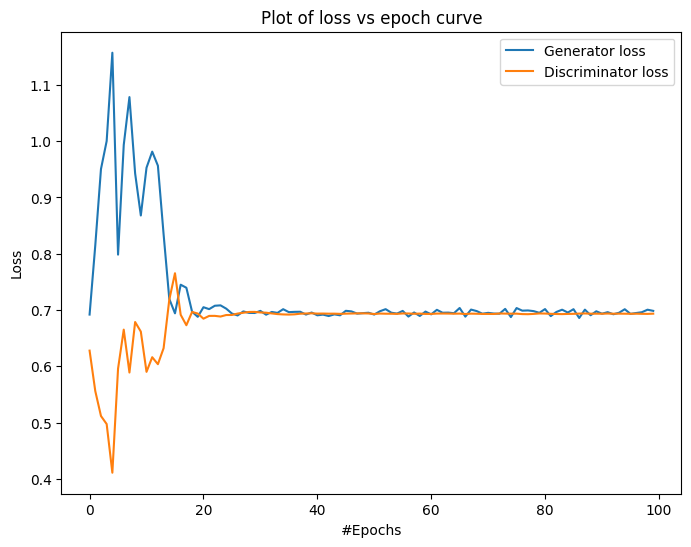

In [68]:
# Plot of loss vs epoch curve
plt.figure(figsize=(8, 6))
plt.title('Plot of loss vs epoch curve')
plt.plot(losses_G, label='Generator loss')
plt.plot(losses_D, label='Discriminator loss')
plt.xlabel('#Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

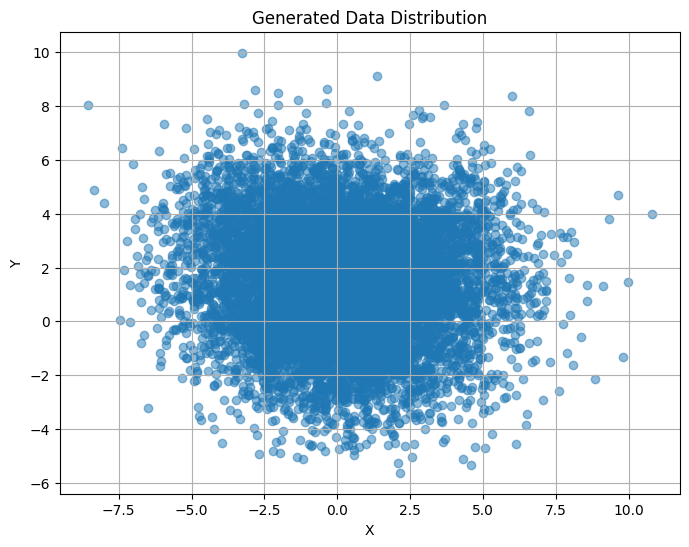

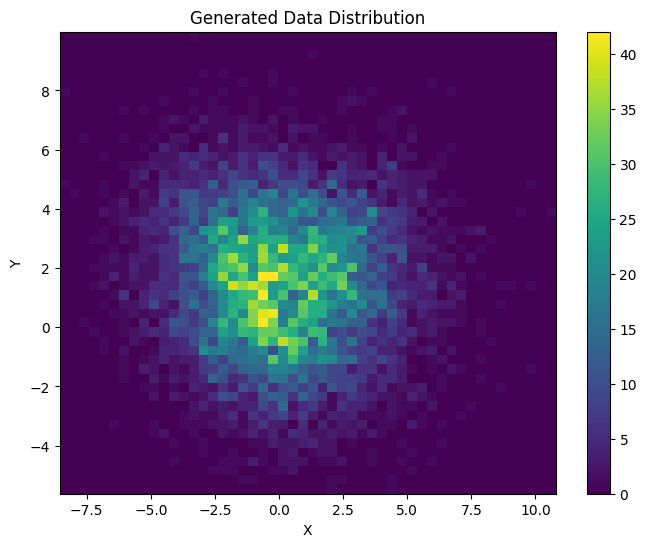

In [66]:
# Generate sample and show a histogram
z = torch.randn(num, latent_dim)
samples = generator(z).detach().numpy()

plt.figure(figsize=(8, 6))
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.5)
plt.title('Generated Data Distribution')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
plt.hist2d(samples[:,0], samples[:,1], bins=50, cmap='viridis')
plt.colorbar()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Generated Data Distribution')
plt.show()